In [1]:
from openbb import obb
import mplfinance as mpf
import pandas as pd

In [72]:
class ChartStructure:
    def __init__(self, df: pd.DataFrame, ticker: str = None):
        self.df = df.copy()
        self.ticker = ticker or "Unknown"

        # Structure annotations
        self.bullish_channels = []     # List of tuples: [(start_idx, end_idx), ...]
        self.bearish_channels = []
        self.ascending_wedges = []
        self.descending_wedges = []

        self.support_levels = []       # List of price values or (idx, price)
        self.resistance_levels = []

    # new and improved channels
    def add_channel(self, lower_start, lower_end, upper_start, upper_end, channel_type="bullish"):
        channel = {
            "lower": (pd.to_datetime(lower_start[0]), lower_start[1], pd.to_datetime(lower_end[0]), lower_end[1]),
            "upper": (pd.to_datetime(upper_start[0]), upper_start[1], pd.to_datetime(upper_end[0]), upper_end[1])
        }

        if channel_type == "bullish":
            self.bullish_channels.append(channel)
        elif channel_type == "bearish":
            self.bearish_channels.append(channel)
        else:
            raise ValueError("channel_type must be 'bullish' or 'bearish'")

    def add_bullish_channel(self, start_idx: int, end_idx: int):
        self.bullish_channels.append((start_idx, end_idx))

    def add_bearish_channel(self, start_idx: int, end_idx: int):
        self.bearish_channels.append((start_idx, end_idx))

    # new and more advanced method of adding wedges
    def add_wedge(self, start_support: tuple, start_resistance: tuple, end_point: tuple, wedge_type: str = "ascending"):
        wedge = {
            "support": (pd.to_datetime(start_support[0]), start_support[1]),
            "resistance": (pd.to_datetime(start_resistance[0]), start_resistance[1]),
            "end": (pd.to_datetime(end_point[0]), end_point[1])
        }
        if wedge_type == "ascending":
            self.ascending_wedges.append(wedge)
        elif wedge_type == "descending":
            self.descending_wedges.append(wedge)
        else:
            raise ValueError("wedge_type must be 'ascending' or 'descending'")

    def add_ascending_wedge(self, start_idx: int, end_idx: int):
        self.ascending_wedges.append((start_idx, end_idx))

    def add_descending_wedge(self, start_idx: int, end_idx: int):
        self.descending_wedges.append((start_idx, end_idx))

    def add_support(self, start: tuple, end: tuple):
        self.support_levels.append((
            pd.to_datetime(start[0]), start[1],
            pd.to_datetime(end[0]), end[1]
        ))

    def add_resistance(self, start: tuple, end: tuple):
        self.resistance_levels.append((
            pd.to_datetime(start[0]), start[1],
            pd.to_datetime(end[0]), end[1]
        ))

    """
    def add_support(self, price: float):
        self.support_levels.append(price)

    def add_resistance(self, price: float):
        self.resistance_levels.append(price)
    """
    def summary(self):
        print(f"\n--- Chart Structure Summary for {self.ticker} ---")
        print(f"Bullish Channels: {self.bullish_channels}")
        print(f"Bearish Channels: {self.bearish_channels}")
        print(f"Ascending Wedges: {self.ascending_wedges}")
        print(f"Descending Wedges: {self.descending_wedges}")
        print(f"Support Levels: {self.support_levels}")
        print(f"Resistance Levels: {self.resistance_levels}")
    
    def _segment(self, idx1, idx2):
        return [(self.df.index[idx1], self.df['low'][idx1]), (self.df.index[idx2], self.df['high'][idx2])]

    def _level_line(self, price):
        return [(self.df.index[0], price), (self.df.index[-1], price)]

    def plot(self):
        alines = []
        colors = []

        # Add channels and wedges
        # Inside plot()
        for wedge in self.ascending_wedges + self.descending_wedges:
            alines.append([(wedge['support'][0], wedge['support'][1]), (wedge['end'][0], wedge['end'][1])])
            alines.append([(wedge['resistance'][0], wedge['resistance'][1]), (wedge['end'][0], wedge['end'][1])])
            colors += ['green', 'red']

        for ch in self.bullish_channels + self.bearish_channels:
            alines.append([(ch['lower'][0], ch['lower'][1]), (ch['lower'][2], ch['lower'][3])])
            alines.append([(ch['upper'][0], ch['upper'][1]), (ch['upper'][2], ch['upper'][3])])
            colors += ['green', 'red']
    
        # Support
        for s in self.support_levels:
            alines.append([(s[0], s[1]), (s[2], s[3])])
            colors.append('green')

        # Resistance
        for r in self.resistance_levels:
            alines.append([(r[0], r[1]), (r[2], r[3])])
            colors.append('red')

        # Plot
        mpf.plot(
            self.df,
            type='candle',
            style='yahoo',
            title=f"{self.ticker} Chart Structures",
            volume=True,
            alines=dict(alines=alines, colors=colors, linewidths=1.2),
        )

This line is important it setst he type of data you are going to be pulling

In [45]:
obb.user.preferences.output_type = "dataframe"

In [6]:
def get_candlestick_chart(ticker):
    data = obb.equity.price.historical(ticker, provider = "yfinance")
    data.index = pd.to_datetime(data.index)
    data = data[['open', 'high', 'low', 'close', 'volume']]

    # Calculate Moving Averages
    data['MA50'] = data['close'].rolling(window=50).mean()
    data['MA25'] = data['close'].rolling(window=25).mean()

    # Calculate RSI
    delta = data['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Build RSI panel
    rsi_panel = mpf.make_addplot(data['RSI'], panel=1, color='orange', ylabel='RSI')

    # Plot candlestick chart with MAs and RSI
    mpf.plot(
        data,
        type='candle',
        style='yahoo',
        title=f"{ticker.upper()} Candlestick Chart",
        volume=True,
        mav=(50, 25),
        addplot=[rsi_panel],
        panel_ratios=(2, 0.75),  # Bigger main chart, smaller RSI
    )

    # mpf.plot(data, type='candle', style='yahoo', title=f"{ticker} Candlestick Chart", volume=True)

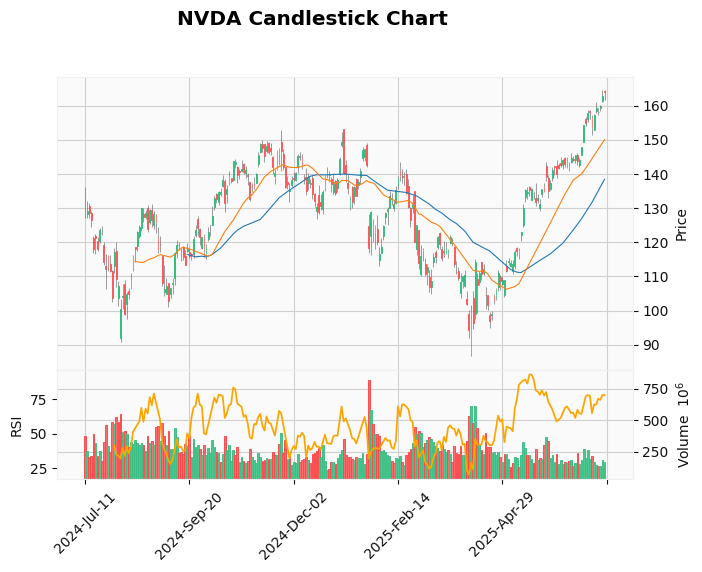

In [7]:
get_candlestick_chart("NVDA")

In [94]:
df = obb.equity.price.historical("NVDA", start_date="2024-06-01")
df.index = pd.to_datetime(df.index)

chart = ChartStructure(df, "NVDA")

"""
chart.add_wedge(
    start_support=("2024-07-01", 530),
    start_resistance=("2024-07-01", 555),
    end_point=("2024-07-10", 545),
    wedge_type="ascending"
)
"""
chart.add_channel(
    lower_start=("2024-09-01", 102),
    lower_end=("2024-11-01", 132),
    upper_start=("2024-09-01", 112),
    upper_end=("2024-11-01", 142),
    channel_type="bullish"
)

chart.add_channel(
    lower_start=("2025-01-01", 130),
    lower_end=("2025-04-15", 90),
    upper_start=("2025-01-01", 155),
    upper_end=("2025-04-15", 115),
    channel_type="bearish"
)

# chart.add_channel(64, 107)
# chart.add_bearish_channel(150, 220)

chart.add_support(("2025-03-01", 95), ("2025-05-01", 95))
chart.add_support(("2024-07-01", 102), ("2024-11-01", 102))
chart.add_resistance(("2024-11-01", 152), ("2025-04-01", 152))
chart.add_support(("2025-06-01", 152), ("2025-7-10", 152))

# chart.add_support(95.0)
# chart.add_resistance(150.0)   # old code

chart.summary()


--- Chart Structure Summary for NVDA ---
Bullish Channels: [{'lower': (Timestamp('2024-09-01 00:00:00'), 102, Timestamp('2024-11-01 00:00:00'), 132), 'upper': (Timestamp('2024-09-01 00:00:00'), 112, Timestamp('2024-11-01 00:00:00'), 142)}]
Bearish Channels: [{'lower': (Timestamp('2025-01-01 00:00:00'), 130, Timestamp('2025-04-15 00:00:00'), 90), 'upper': (Timestamp('2025-01-01 00:00:00'), 155, Timestamp('2025-04-15 00:00:00'), 115)}]
Ascending Wedges: []
Descending Wedges: []
Support Levels: [(Timestamp('2025-03-01 00:00:00'), 95, Timestamp('2025-05-01 00:00:00'), 95), (Timestamp('2024-07-01 00:00:00'), 102, Timestamp('2024-11-01 00:00:00'), 102), (Timestamp('2025-06-01 00:00:00'), 152, Timestamp('2025-07-10 00:00:00'), 152)]
Resistance Levels: [(Timestamp('2024-11-01 00:00:00'), 152, Timestamp('2025-04-01 00:00:00'), 152)]


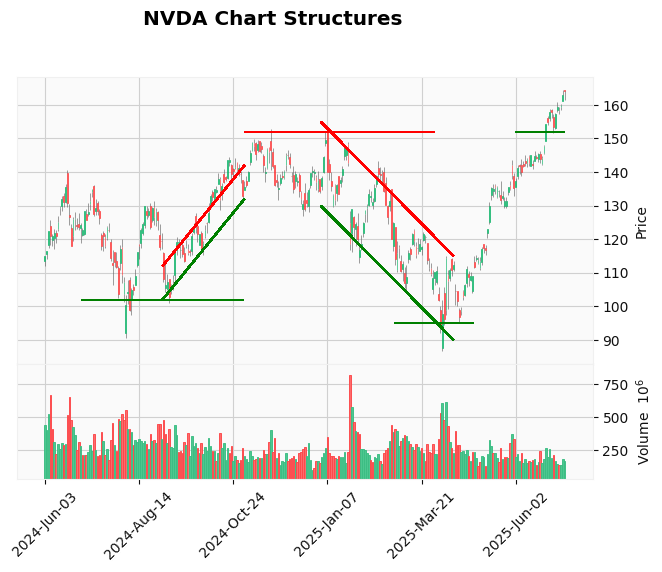

In [95]:
chart.plot()